In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import torch

In [3]:
os.chdir('/content/drive/My Drive/UPDVRP_MCD')

In [4]:
from torch.utils.data import DataLoader
from generate_data import generate_vrp_data
from utils import load_model
from problems import UPDVRP

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
  """
    Create an N-bin discrete colormap from the specified input map
    """
  # Note that if base_cmap is a string or None, you can simply do
  #    return plt.cm.get_cmap(base_cmap, N)
  # The following works for string, None, or a colormap instance:

  base = plt.cm.get_cmap(base_cmap)
  color_list = base(np.linspace(0, 1, N))
  cmap_name = base.name + str(N)
  return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=10, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1, including pickup and delivery demands.
    """
    # route is one sequence, separating different routes with 0 (depot)
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    delivery_demands = data['delivery'].cpu().numpy()
    pickup_demands = data['pickup'].cpu().numpy()

    ax1.plot(depot[0], depot[1], 'sk', markersize=markersize*4)  # Depot location
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    qvs = []  # For storing quiver objects for legend
    total_dist = 0

    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order

        delivery_route_demands = delivery_demands[r - 1]
        pickup_route_demands = pickup_demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)  # Route nodes

        dist = np.linalg.norm(np.vstack([xs, ys]).T - np.roll(np.vstack([xs, ys]).T, 1, axis=0), axis=1).sum()
        total_dist += dist
        qv = ax1.quiver(xs[:-1], ys[:-1], xs[1:] - xs[:-1], ys[1:] - ys[:-1], scale_units='xy', angles='xy', scale=1, color=color)

        qvs.append(qv)

        ax1.plot([depot[0], xs[0]], [depot[1], ys[0]], color=color, linewidth=1)
        # Line from the last node to depot
        ax1.plot([xs[-1], depot[0]], [ys[-1], depot[1]], color=color, linewidth=1)

        # Visualize demands if enabled
        if visualize_demands:
            for (x, y), pickup, delivery in zip(coords, pickup_route_demands, delivery_route_demands):
                # Scaled rectangles for visualization
                pickup_rect = Rectangle((x - 0.005, y), 0.01, 0.1 * pickup / demand_scale, color='green')
                delivery_rect = Rectangle((x, y), 0.01, 0.1 * delivery / demand_scale, color='red')
                ax1.add_patch(pickup_rect)
                ax1.add_patch(delivery_rect)

    ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
    ax1.legend(handles=qvs, loc='upper center')

    if visualize_demands:
        # Add custom legend for demands
        ax1.add_patch(Rectangle((0, 0), 0.01, 0.1, color='green', label='Pickup'))
        ax1.add_patch(Rectangle((0, 0), 0.01, 0.1, color='red', label='Delivery'))
        ax1.legend(loc='upper center')

In [20]:
def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=10, round_demand=False):
    """
    Plot the vehicle routes on matplotlib axis ax1, including pickup and delivery demands.
    """
    # Split the route by the depot identifier (0), filter out empty routes
    routes = [r[r!=0] for r in np.split(route.cpu().numpy(), np.where(route==0)[0]) if (r != 0).any()]
    depot = data['depot'].cpu().numpy()
    locs = data['loc'].cpu().numpy()
    delivery_demands = data['delivery'].cpu().numpy() if visualize_demands else None
    pickup_demands = data['pickup'].cpu().numpy() if visualize_demands else None

    # Plot the depot
    ax1.plot(depot[0], depot[1], 'sk', markersize=markersize*4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    # Create a discrete colormap
    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    qvs = []  # For storing quiver objects for legend
    total_dist = 0  # Initialize total distance

    try:
        for veh_number, r in enumerate(routes):
            color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order
            coords = locs[r - 1, :]
            xs, ys = coords.transpose()

            # Plot the route nodes
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)

            # Draw lines between nodes
            qv = ax1.quiver(xs[:-1], ys[:-1], xs[1:] - xs[:-1], ys[1:] - ys[:-1], scale_units='xy', angles='xy', scale=1, color=color)
            qvs.append(qv)

            # Calculate and accumulate the distance
            dist = np.linalg.norm(np.vstack([xs, ys]).T - np.roll(np.vstack([xs, ys]).T, 1, axis=0), axis=1).sum()
            total_dist += dist

            # Draw lines linking to the depot
            ax1.plot([depot[0], xs[0]], [depot[1], ys[0]], color=color, linewidth=1)  # First node to depot
            ax1.plot([xs[-1], depot[0]], [ys[-1], depot[1]], color=color, linewidth=1)  # Last node to depot

            # Visualize demands if enabled
            if visualize_demands:
                for (x, y), pickup, delivery in zip(coords, pickup_route_demands, delivery_route_demands):
                    # Scaled rectangles for visualization
                    pickup_rect = Rectangle((x - 0.005, y), 0.01, 0.1 * pickup / demand_scale, color='green')
                    delivery_rect = Rectangle((x, y), 0.01, 0.1 * delivery / demand_scale, color='red')
                    ax1.add_patch(pickup_rect)
                    ax1.add_patch(delivery_rect)

        # Set title and legend
        ax1.set_title('{} routes, total distance {:.2f}'.format(len(routes), total_dist))
        ax1.legend(handles=qvs, loc='upper center')

        if visualize_demands:
            # Custom legend for demands
            green_patch = Rectangle((0, 0), 0.01, 0.1, color='green', label='Pickup')
            red_patch = Rectangle((0, 0), 0.01, 0.1, color='red', label='Delivery')
            ax1.legend(handles=[green_patch, red_patch], loc='upper center')

    except Exception as e:
        print(f"Error plotting vehicle routes: {e}")

In [6]:
model, _ = load_model('outputs/updvrp_20_20/pretrained/epoch-55.pt')
torch.manual_seed(1234)
dataset = UPDVRP.make_dataset(foodbank = 20, num_products = 20, num_samples = 10)

  [*] Loading model from outputs/updvrp_20_20/pretrained/epoch-55.pt


In [7]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1000)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')
with torch.no_grad():
    length, log_p, pi = model(batch, return_pi=True, beta = 10)
tours = pi

<ipython-input-10-c389d4ae6c2f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)
<ipython-input-20-3b27e22c3308>:54: UserWarning: The label '_child2' of <matplotlib.quiver.Quiver object at 0x7de609d0a8f0> starts with '_'. It is thus excluded from the legend.
  ax1.legend(handles=qvs, loc='upper center')
<ipython-input-20-3b27e22c3308>:54: UserWarning: The label '_child2' of <matplotlib.quiver.Quiver object at 0x7de60c792860> starts with '_'. It is thus excluded from the legend.
  ax1.legend(handles=qvs, loc='upper center')
<ipython-input-20-3b27e22c3308>:54: UserWarning: The label '_child2' of <matplotlib.quiver.Quiver object at 0x7de60c8aa440> starts with '_'. It is thus excluded from the legend.
  ax1.legend(handles=qvs, loc='upper center')
<ipython-input-20-3b27e22c3308>:54: Use

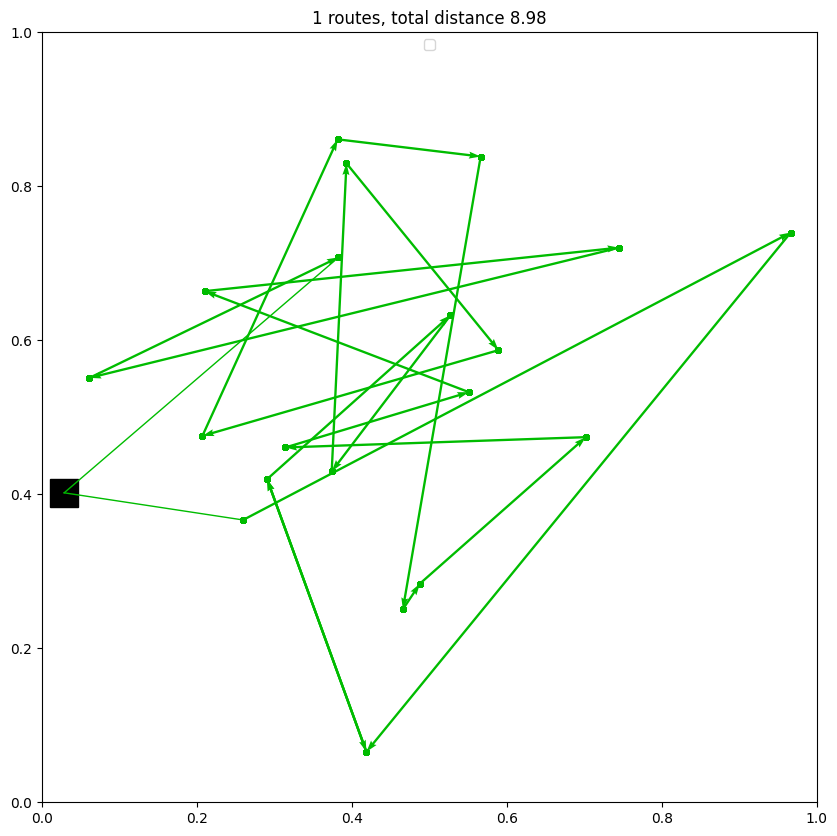

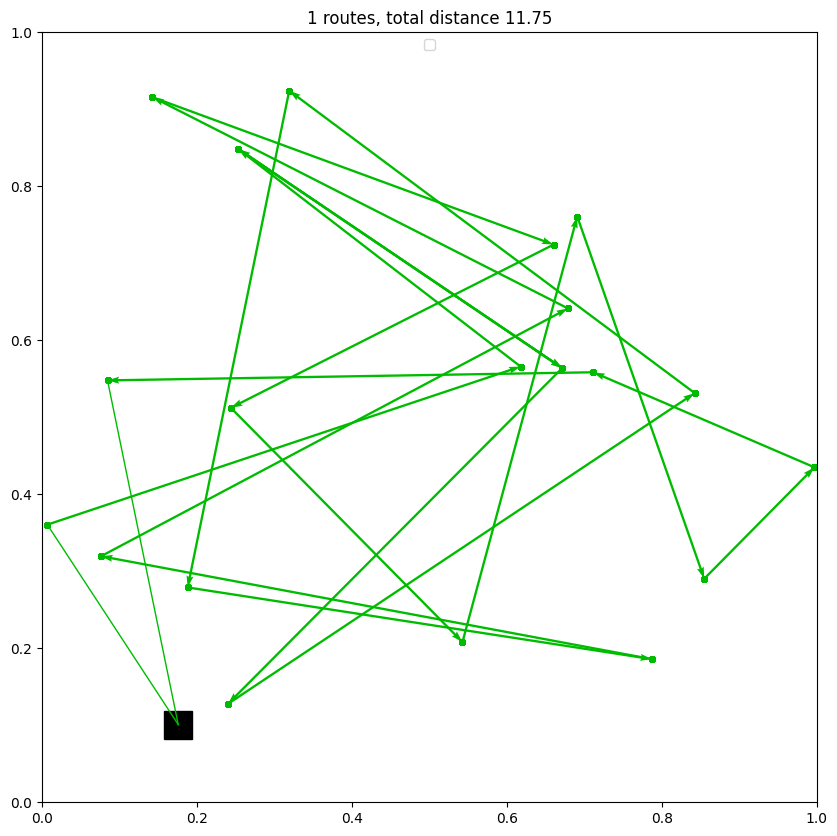

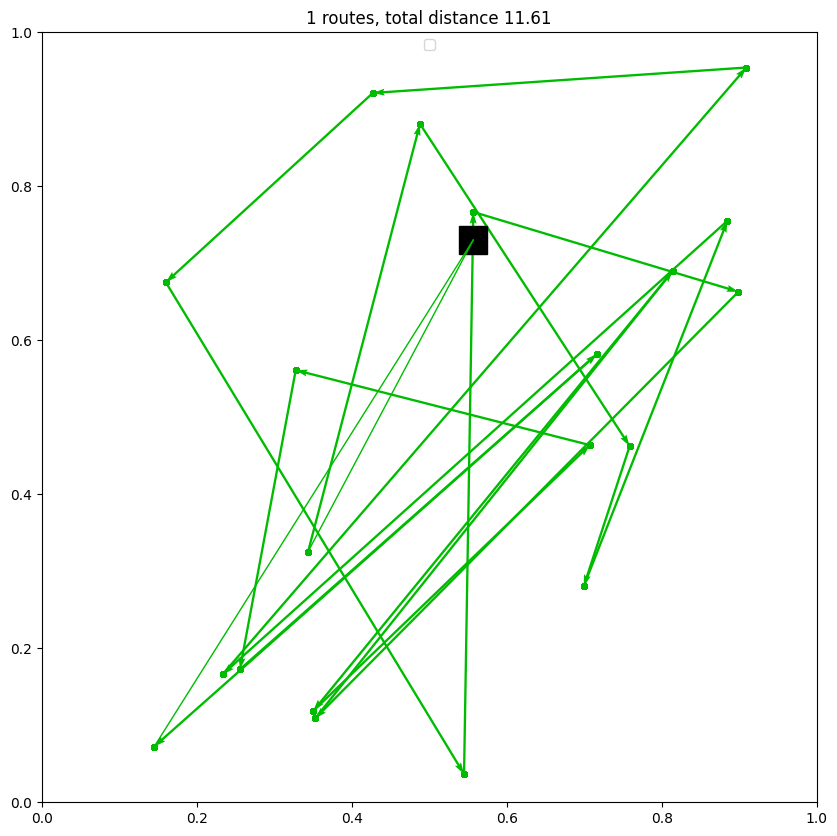

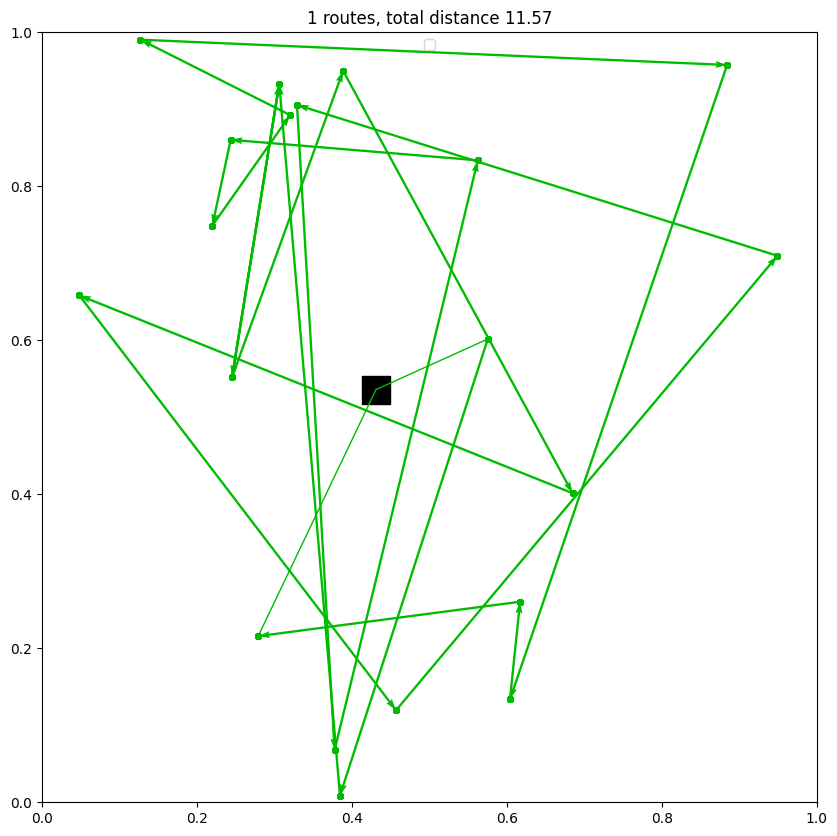

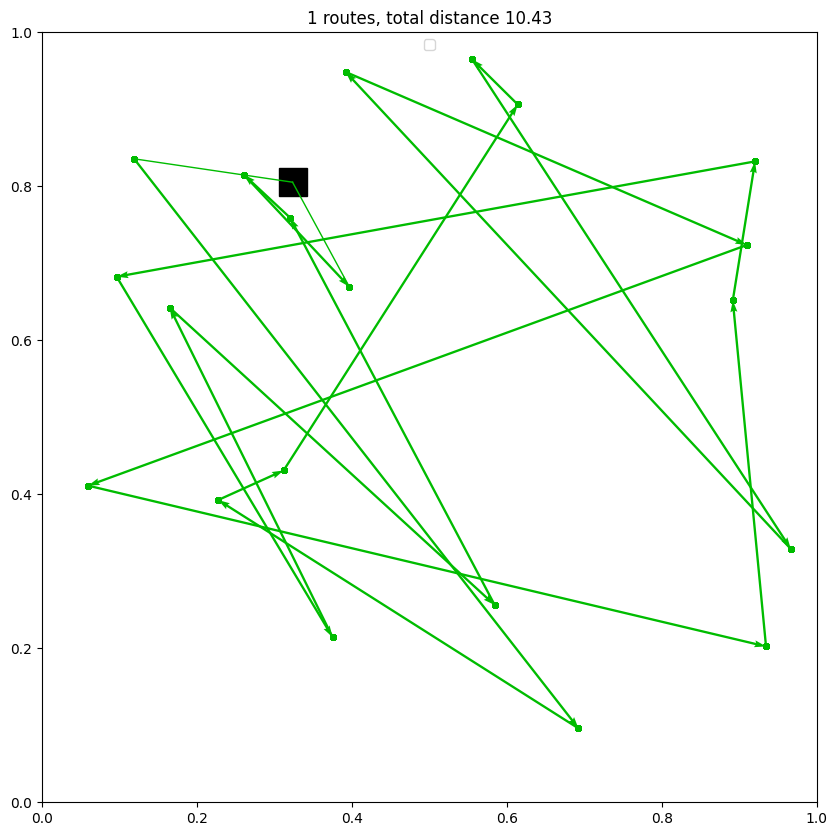

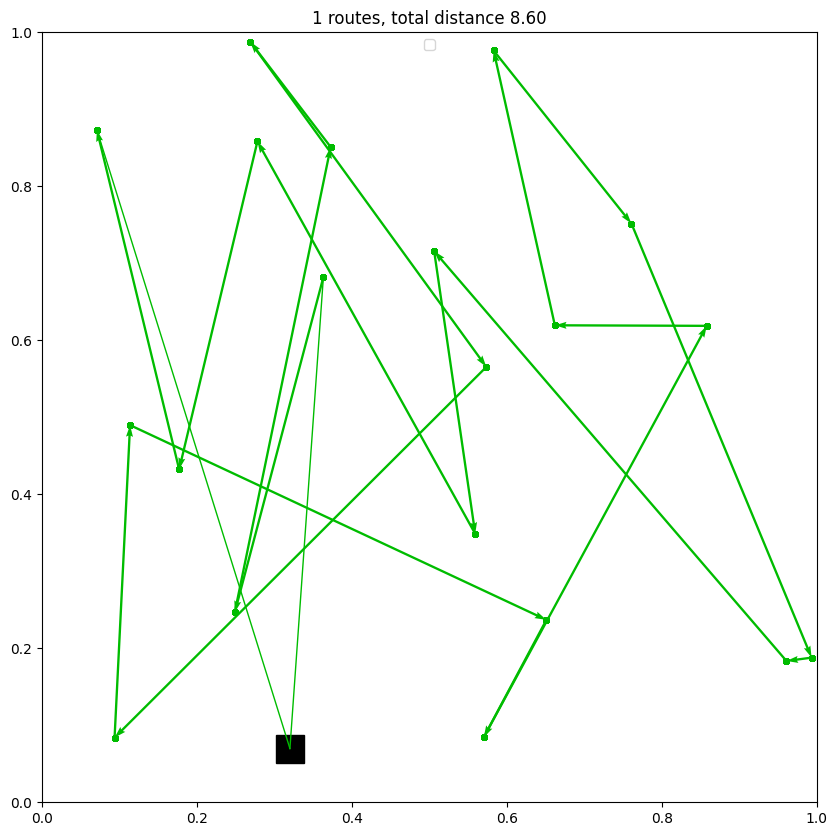

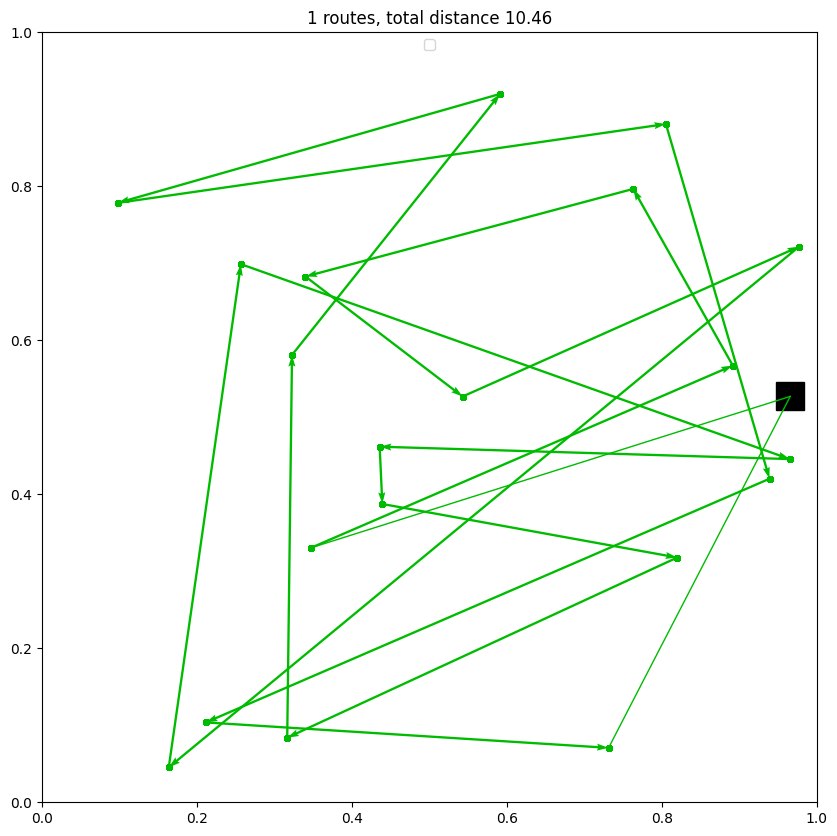

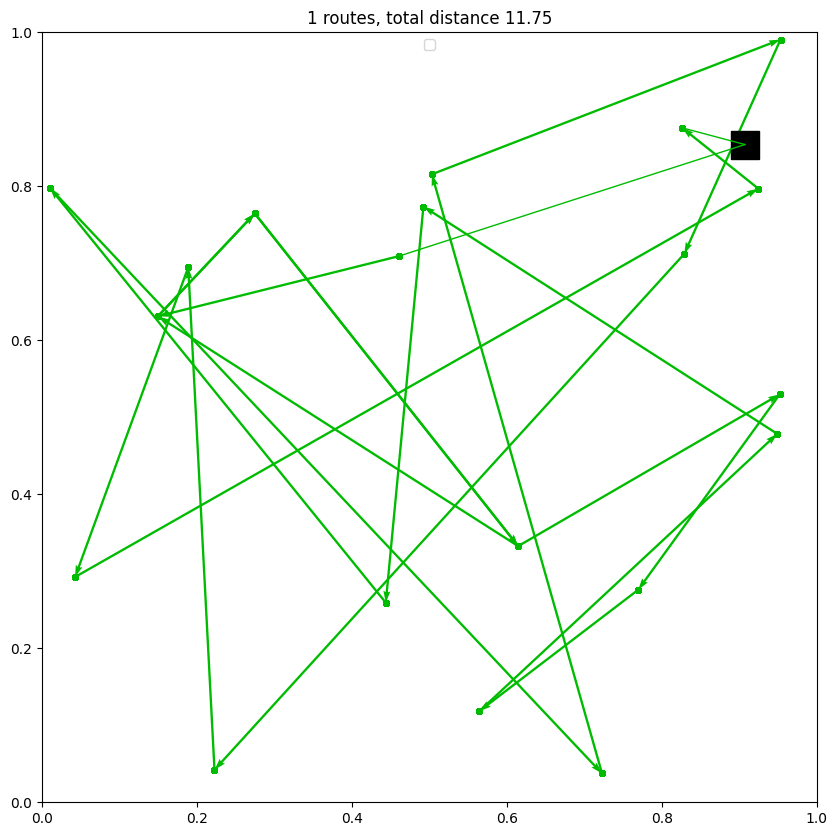

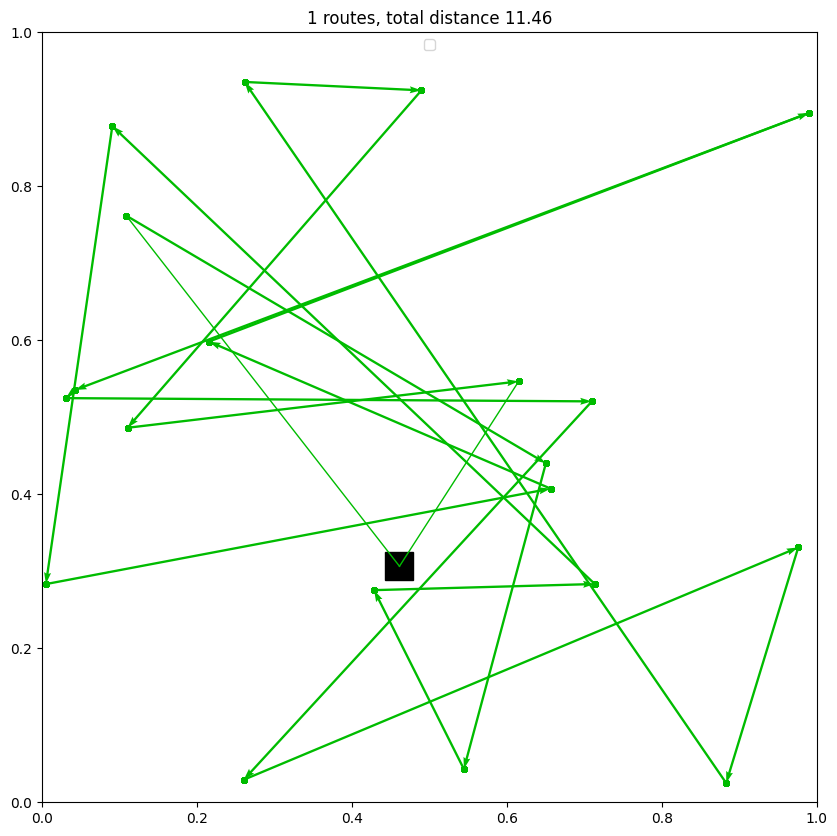

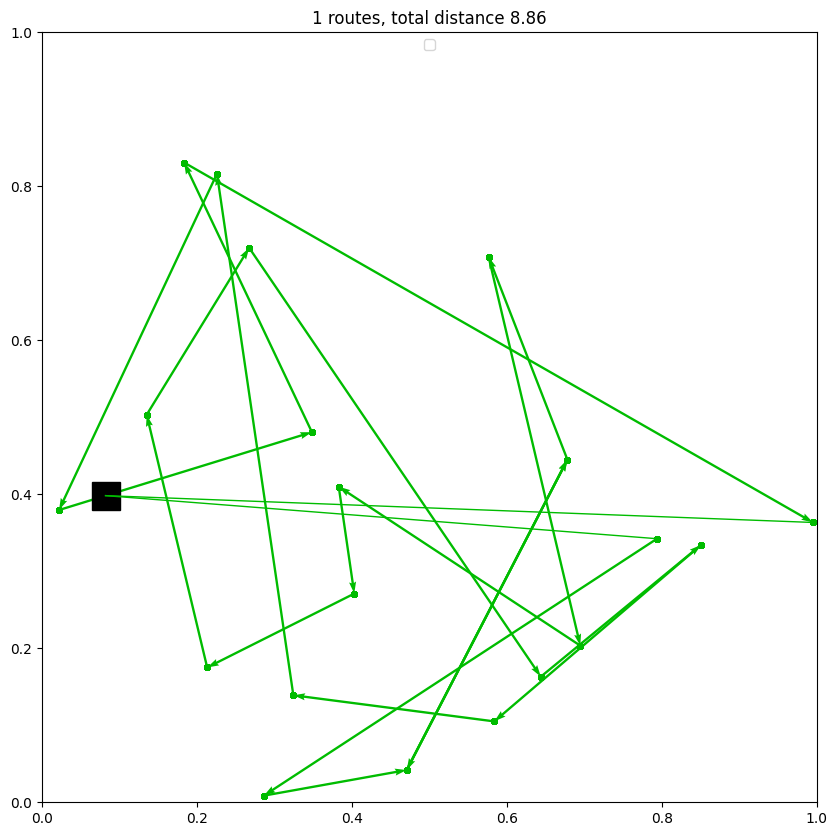

In [22]:
# Plot the results
for i, (data, tour) in enumerate(zip(dataset, tours)):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=1, round_demand=True)
    # fig.savefig(os.path.join('images', 'cvrp_{}.png'.format(i)))